In [1]:
import cv2
import numpy as np
import scipy as sp
from PIL import Image
from scipy.ndimage.measurements import label
from skimage.measure import regionprops
from skimage import data
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
import xml.etree.ElementTree as ET
import os
import time
import pandas as pd

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config =  ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# session = InteractiveSession(config=config)

In [2]:
def normalization(x):
  return (x-np.min(x))/(np.max(x)-np.min(x))

def energy_point_game(bbox, saliency_map): # GT 부분의 활성화 값 / 전체 활성화 값
  x1, y1, x2, y2 = bbox
  w, h = saliency_map.shape
  
  empty = np.zeros((w, h))
  empty[y1:y2, x1:x2] = 1
  mask_bbox = saliency_map * empty  
  
  energy_bbox =  mask_bbox.sum()
  energy_whole = saliency_map.sum()
  proportion = energy_bbox / energy_whole
  
  return proportion

def get_label(xml):
  p_size = xml.find('size')
  p_box = xml.find('object').find('bndbox')
  size = {'width':int(p_size.find('width').text),'height': int(p_size.find('height').text)}
  box = {'xmin':int(p_box.find('xmin').text), 'ymin' : int(p_box.find('ymin').text),'xmax': int(p_box.find('xmax').text),'ymax': int(p_box.find('ymax').text)}
  xmin, ymin, xmax, ymax = box['xmin'] / size['width'] * 224, box['ymin'] / size['height'] * 224, box['xmax'] / size['width'] * 224,box['ymax'] / size['height'] * 224
  w, h = xmax - xmin, ymax - ymin
  return {'xmin':xmin, 'ymin':ymin, 'xmax':xmax,'ymax':ymax,'w':w, 'h':h}

In [3]:
class SISE():
    def __init__(self, model, model_name, img_path, class_idx) -> None:
        self.model = model
        self.input_size = model.input_shape[1:3]
        self.model_name = model_name
        self.feature_maps = {}
        self.img = Image.open(img_path).resize((224, 224))
        img_arr = np.asarray(self.img)[:, :, :3] / 255.
        self.input_img = np.expand_dims(img_arr, 0)
        self.class_idx = class_idx
        self.filtered_feature_maps = {}
        self.postprocessed_feature_maps = {}
        self.layer_visualization_maps = {}
        self.total_reduction_rate = 0
        self.result = None
    
    def feature_extractor(self):
        if self.model_name=='vgg16':
            # Feature map을 추출할 layer 결정
            block = [1, 4, 8, 12, 16]
            outputs = [self.model.layers[i].output for i in block]
            feature_map_extraction_model = Model([self.model.inputs], outputs)

            # Layer별 feature map 추출
            feature_maps = {}
            feature_maps_list = feature_map_extraction_model.predict(self.input_img)

            for i, fmap in enumerate(feature_maps_list):
                feature_maps[f'conv{i}'] = tf.convert_to_tensor(np.squeeze(fmap))

            self.feature_maps = feature_maps
        else:
            print('Not support')

    def feature_filtering(self):
        if self.model_name == 'vgg16':
            # conv layer별 피쳐맵과 confidence score(softmax 값)의 gradient 계산
            block = [1, 4, 8, 12, 16, 18]
            outputs = [self.model.layers[i].output for i in block]

            grad_model = Model([self.model.inputs], outputs)

            with tf.GradientTape(persistent=True) as tape:
                *conv_outputs, pred = grad_model(self.input_img)
                class_channel = pred[:, self.class_idx]

            grads = {}
            for i, conv in enumerate(conv_outputs):
                grads[f'conv{i}'] = tape.gradient(class_channel, conv)[0]

            # 피쳐맵의 평균 gradient 계산
            avg_grads = {}
            for k, v in grads.items():
                avg_grads[k] = tf.reduce_mean(v, axis=(0,1))

            # 피쳐맵의 평균 gradient가 0이 넘는 피쳐맵만 필터링
            filtered_feature_maps = {}
            for k, v in avg_grads.items():
                transpose = tf.transpose(self.feature_maps[k], perm=[2,0,1])[v>0] # 필터링 용이를 위해 transpose
                filtered_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

            # 필터링 된 피쳐맵 수 비교
            sum1 = sum2 = 0
            for k1, k2 in zip(avg_grads.values(), filtered_feature_maps.values()):
                # print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
                sum1 += len(k1)
                sum2 += k2.shape[-1]

            # print('\nTotal')
            # print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')

            self.filtered_feature_maps = filtered_feature_maps
            self.total_reduction_rate = (sum2-sum1)/sum1*100

    def postprocess(self):
        # Bilinear interpolation
        postprocessed_feature_maps = {}
        for k in self.filtered_feature_maps.keys():
            postprocessed_feature_maps[k] = cv2.resize(self.filtered_feature_maps[k].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)
            for i in range(postprocessed_feature_maps[k].shape[-1]):
                if np.max(postprocessed_feature_maps[k][:,:,i]) == 0.0:
                    continue
                postprocessed_feature_maps[k][:,:,i] = (postprocessed_feature_maps[k][:,:,i] - np.min(postprocessed_feature_maps[k][:,:,i]))/(np.max(postprocessed_feature_maps[k][:,:,i])-np.min(postprocessed_feature_maps[k][:,:,i]))

        self.postprocessed_feature_maps = postprocessed_feature_maps

    def generate_layer_visualization_map(self):
        layer_visualization_maps = {}
        for k in self.postprocessed_feature_maps.keys():
            masks = np.expand_dims(tf.transpose(self.postprocessed_feature_maps[k], perm=[2,0,1]), axis=-1)
            masked = self.input_img*masks
            preds = self.model.predict(masked)
            layer_visualization_maps[k] = preds.T.dot(masks.reshape(masks.shape[0],-1)).reshape(-1, 224,224)

        self.layer_visualization_maps = layer_visualization_maps

    def layers_fusion(self):
        result = normalization(self.layer_visualization_maps['conv0'][self.class_idx]).copy()

        for k in self.layer_visualization_maps.keys():
            if k == 'conv0':
                continue
            result += self.layer_visualization_maps[k][self.class_idx]
            thr = filters.threshold_otsu(normalization(self.layer_visualization_maps[k][self.class_idx]))
            binary = normalization(self.layer_visualization_maps[k][self.class_idx]) > thr
            binary = np.multiply(binary, 255)
            result = result * binary

        self.result = result

In [4]:
model = load_model('model/vgg16_voc2007')

In [5]:
test = SISE(model, 'vgg16', '000258.jpg', 11)
test.feature_extractor()
test.feature_filtering()
test.postprocess()
test.generate_layer_visualization_map()
test.layers_fusion()

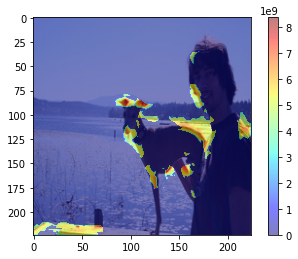

In [6]:
plt.imshow(test.img)
plt.imshow(test.result, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

In [5]:
classese = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

In [6]:
label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
test_data_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/test'

ebpg_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()

for class_name, class_index in classese.items():
    print(class_name)
    for label in os.listdir(f'{test_data_path}/{class_name}'):    
        tree = ET.parse(f'{label_path}/{label.replace(".jpg", ".xml")}')
        root = tree.getroot()
        bbox = get_label(root)

        start = time.time()
        test = SISE(model, 'vgg16', f'{test_data_path}/{class_name}/{label}', class_index)
        test.feature_extractor()
        test.feature_filtering()
        test.postprocess()
        test.generate_layer_visualization_map()
        test.layers_fusion()
        end = time.time()

        ebpg_result.append(energy_point_game((round(bbox['xmin']), round(bbox['ymin']), round(bbox['xmax']), round(bbox['ymax'])), test.result))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(test.total_reduction_rate)


aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


In [7]:
print('Mean EBPG:', sum(ebpg_result)/len(ebpg_result))
print('Mean elapsed time:', sum(elapsed_time_list)/len(elapsed_time_list))
print('Mean total reduction rate:', sum(total_reduction_rate_list)/len(total_reduction_rate_list))

Mean EBPG: 0.4694934864475586
Mean elapsed time: 3.841965532296057
Mean total reduction rate: -49.865496298798945


In [8]:
df = pd.DataFrame({'ebpg result':ebpg_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})

In [9]:
df.to_excel(excel_writer='SISE_vgg16_0107.xlsx')

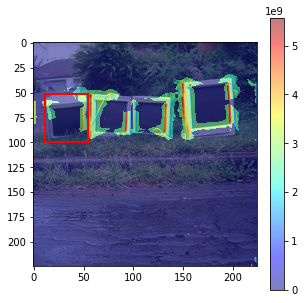

In [30]:
plt.figure(figsize=(5,5))
plt.imshow(test.img)
plt.imshow(test.result, cmap='jet', alpha=0.5)
plt.colorbar()
ax = plt.gca()
rect = patches.Rectangle((bbox['xmin'], bbox['ymin']), bbox['w'], bbox['h'], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()